In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import itertools

##Code for Monte Carlo pricing of options

In [ ]:
def dS(St,mu,sig,dt):
  """Generates the change in the stock price
  for Monte Carlo Simulation."""

  eps = np.random.normal(0,1,1)
  return mu*St*dt + sig*St*eps*math.sqrt(dt)

In [ ]:
def StockEvo(S0,mu,sig,dt,T):
  """Generates a full time series for an underlying
  asset."""
  St = []
  St.append(S0)

  N = int(T/dt)

  for n in range(N):
    delta = dS(St[-1],mu,sig,dt)
    St.append(St[-1] + delta)

  return St

In [ ]:
def MonteCarlo(S0,mu,sig,dt,T,M):
  """Generates M different instances of
  the evolution of an underlying asset."""
  
  N = int(T/dt) + 1
  results = np.zeros((M,N))
  #split = (1-CI)/2

  for m in range(M):
    results[m,:] = StockEvo(S0,mu,sig,dt,T)
  
  #mean = np.mean(results,axis=0)
  #UB = np.quantile(results,CI+split,axis=0)
  #LB = np.quantile(results,split,axis=0)

  return results

In [ ]:
def AsianCall(Prices,K,CI):
  """Calculates the expected value at 
  maturity for an Asian call with strike
  price K."""

  means = np.mean(Prices,axis=1)
  call = np.maximum(means-K,0)

  split = (1-CI)/2
  LB, UB = np.quantile(call,[split,CI+split])

  return (np.mean(call),UB,LB)

In [ ]:
def AsianPut(Prices,K,CI):
  """Calculates the expected value at 
  maturity for an Asian put with strike
  price K."""
  
  means = np.mean(Prices,axis=1)
  put = np.maximum(K-means,0)
  split = (1-CI)/2
  LB, UB = np.quantile(put,[split,CI+split])

  return (np.mean(put),UB,LB)

In [ ]:
def LookbackCall(Prices,K,CI):
  """Calculates the expected value at 
  maturity for an Lookback call with strike
  price K."""
  
  maxs = np.max(Prices,axis=1)
  call = np.maximum(maxs-K,0)

  split = (1-CI)/2
  LB, UB = np.quantile(call,[split,CI+split])

  return (np.mean(call),UB,LB)

In [ ]:
def LookbackPut(Prices,K,CI):
  """Calculates the expected value at 
  maturity for an Lookback put with strike
  price K."""
  
  mins = np.min(Prices,axis=1)
  put = np.maximum(K-mins,0)
  split = (1-CI)/2
  LB, UB = np.quantile(put,[split,CI+split])

  return (np.mean(put),UB,LB)

In [ ]:
def FloatLBCall(Prices,CI):
  """Calculates the expected value at 
  maturity for an Floating Lookback call 
  with strike price K."""

  mins = np.min(Prices,axis=1)
  call = np.maximum(Prices[:,-1] - mins,0)

  split = (1-CI)/2
  LB, UB = np.quantile(call,[split,CI+split])

  return (np.mean(call),UB,LB)

In [ ]:
def FloatLBPut(Prices,CI):
  """Calculates the expected value at 
  maturity for an Floating Lookback put 
  with strike price K."""
  
  maxs = np.max(Prices,axis=1)
  put = np.maximum(maxs - Prices[:,-1],0)
  split = (1-CI)/2
  LB, UB = np.quantile(put,[split,CI+split])

  return (np.mean(put),UB,LB)

In [ ]:
mu = 0.02
sig = 0.25
S0 = 100
dt = 1/52
T = 8/52
M = 256

np.random.seed(1992)
#Generate 256 instances of the asset
results= MonteCarlo(S0,mu,sig,dt,T,M)

In [ ]:
#Place everything into a dataframe
funcs = {'Asian Call':AsianCall,'Asian Put': AsianPut, 'Lookback Call': LookbackCall,\
         'Lookback Put': LookbackPut, 'Floating Lookback Call': FloatLBCall,\
         'Floating Lookback Put': FloatLBPut}

df_mature = pd.DataFrame(index=funcs.keys(),columns=['Monte Price'])
for key in funcs.keys():

  if 'Floating' in key:

    mean,UB,LB = funcs[key](results,0.95)
    df_mature.loc[key,'Monte Price'] = mean
    #df_mature.loc[key,'LowerBound'] = LB
    #df_mature.loc[key,'UpperBound'] = UB
  else:
    mean,UB,LB = funcs[key](results,105,0.95)
    df_mature.loc[key,'Monte Price'] = mean
    #df_mature.loc[key,'LowerBound'] = LB
    #df_mature.loc[key,'UpperBound'] = UB

    

In [ ]:
#Adjust the price at maturity to the present
#value (discount rate)
df_price = df_mature*math.exp(-mu*T)

In [ ]:
df_price

,Monte Price
Asian Call,0.564489
Asian Put,5.35272
Lookback Call,2.88549
Lookback Put,10.572
Floating Lookback Call,5.78106
Floating Lookback Put,5.93758


##Code for binomial lattice pricing of options

In [ ]:
def BinomialLattice(S0,mu,sig,dt,T):
  """Generates a binomial lattice."""

  u = math.exp(sig*math.sqrt(dt))
  d = 1/u
  #p = 0.5+ 0.5*(mu/sig)*math.sqrt(dt)

  N = int(T/dt) + 1

  tree = np.zeros((N,N))
  tree[0,0] = S0
  for n in range(1,N):
    for j in range(n+1):
      tree[j,n] = S0*u**(n-j)*d**j
  
  return tree

In [ ]:
def PlotBinomial(tree,dt,T,save=False,prices=[],early=[]):
  """Plots a binomial lattice generated
  by the BinomialLattice func."""

  X = []
  Y = []
  t = np.arange(0,int(T/dt)+1,1)
  labels = []
  early_color = []

  for n in range(int(T/dt)+1):

    plt.plot(t[n:],tree[n,n:],'b--',alpha=0.5)
    plt.plot(t[n:],tree.diagonal(n),'b--',alpha=0.5)

    for j in range(n+1):
      Y.append(tree[j,n])
      X.append(t[n])
      if prices:
        labels.append(prices[int(T/dt)-n][j])
      if early:
        if (n,j) in early:
          early_color.append('red')
        else:
          early_color.append('black')
    
  plt.scatter(X,Y)
  if prices:
    ax = plt.gca()
    for n in range(len(labels)):
      txt = np.round(labels[n],decimals=2)
      if early:
        ax.annotate(txt,(X[n],Y[n]),(X[n]+0.2,Y[n]-1),weight='bold',color=early_color[n])
      else:
        ax.annotate(txt,(X[n],Y[n]),(X[n]+0.2,Y[n]-1),weight='bold')

  plt.grid()
  plt.xlabel('Week')
  plt.ylabel('Asset Price')
  plt.xlim((-0.5,T/dt+1.5))
  if save:
    plt.savefig('tree.png')
  else:
    plt.show()


In [ ]:
def BinomialPath(S0,mu,sig,dt,depth):
  """Generates the 2^N binomial paths for a
  binomial lattice.  Used in pricing path 
  dependent options."""
  
  u = math.exp(sig*math.sqrt(dt))
  d = 1/u
  N = 2**depth
  path_geo = np.array(list(itertools.product([u,d],repeat=depth)))

  paths = np.ones((N,1))* S0

  for n in range(depth):
    paths = np.hstack((paths,np.multiply(paths[:,-1].reshape(N,1)\
                                         ,path_geo[:,n].reshape(N,1))))
  
  return paths

In [ ]:
def AsianCall_Lattice(Prices,K,mu,sig,dt):
  """Returns the present value of an 
  Asian call using the lattice method."""
  
  u = math.exp(sig*math.sqrt(dt))
  d = 1/u
  p = (math.exp(mu*dt) - d)/(u-d)

  final_value = np.maximum(np.mean(Prices,axis=1)-K,0)

  N = int(np.log2(np.size(final_value)))
  val_tree = [final_value]
  for n in range(1,N):

    temp = []
    for j in range(2**(N-n)):
      value = math.exp(-mu*dt)*\
      (p*val_tree[n-1][j*2]+(1-p)*val_tree[n-1][j*2+1])
      temp.append(value)
    
    val_tree.append(np.array(temp))
  
  return math.exp(-mu*dt)*(p*val_tree[-1][0] + (1-p)*val_tree[-1][1])
    

In [ ]:
def AsianPut_Lattice(Prices,K,mu,sig,dt):
  """Returns the present value of an 
  Asian put using the lattice method."""
  u = math.exp(sig*math.sqrt(dt))
  d = 1/u
  p = (math.exp(mu*dt) - d)/(u-d)

  final_value = np.maximum(K-np.mean(Prices,axis=1),0)

  N = int(np.log2(np.size(final_value)))
  val_tree = [final_value]
  for n in range(1,N):

    temp = []
    for j in range(2**(N-n)):
      value = math.exp(-mu*dt)*\
      (p*val_tree[n-1][j*2]+(1-p)*val_tree[n-1][j*2+1])
      temp.append(value)
    
    val_tree.append(np.array(temp))
  
  return math.exp(-mu*dt)*(p*val_tree[-1][0] + (1-p)*val_tree[-1][1])

In [ ]:
def LookbackCall_Lattice(Prices,K,mu,sig,dt):
  """Returns the present value of an 
  lookback call using the lattice method."""

  u = math.exp(sig*math.sqrt(dt))
  d = 1/u
  p = (math.exp(mu*dt) - d)/(u-d)

  final_value = np.maximum(np.max(Prices,axis=1)-K,0)

  N = int(np.log2(np.size(final_value)))
  val_tree = [final_value]
  for n in range(1,N):

    temp = []
    for j in range(2**(N-n)):
      value = math.exp(-mu*dt)*\
      (p*val_tree[n-1][j*2]+(1-p)*val_tree[n-1][j*2+1])
      temp.append(value)
    
    val_tree.append(np.array(temp))
  
  return math.exp(-mu*dt)*(p*val_tree[-1][0] + (1-p)*val_tree[-1][1])

In [ ]:
def LookbackPut_Lattice(Prices,K,mu,sig,dt):
  """Returns the present value of an 
  lookback put using the lattice method."""
  
  u = math.exp(sig*math.sqrt(dt))
  d = 1/u
  p = (math.exp(mu*dt) - d)/(u-d)

  final_value = np.maximum(K-np.min(Prices,axis=1),0)

  N = int(np.log2(np.size(final_value)))
  val_tree = [final_value]
  for n in range(1,N):

    temp = []
    for j in range(2**(N-n)):
      value = math.exp(-mu*dt)*\
      (p*val_tree[n-1][j*2]+(1-p)*val_tree[n-1][j*2+1])
      temp.append(value)
    
    val_tree.append(np.array(temp))
  
  return math.exp(-mu*dt)*(p*val_tree[-1][0] + (1-p)*val_tree[-1][1])

In [ ]:
def FloatLBCall_Lattice(Prices,mu,sig,dt):
  """Returns the present value of an floating
  lookback call using the lattice method."""
  
  u = math.exp(sig*math.sqrt(dt))
  d = 1/u
  p = (math.exp(mu*dt) - d)/(u-d)

  final_value = np.maximum(Prices[:,-1]-np.min(Prices,axis=1),0)

  N = int(np.log2(np.size(final_value)))
  val_tree = [final_value]
  for n in range(1,N):

    temp = []
    for j in range(2**(N-n)):
      value = math.exp(-mu*dt)*\
      (p*val_tree[n-1][j*2]+(1-p)*val_tree[n-1][j*2+1])
      temp.append(value)
    
    val_tree.append(np.array(temp))
  
  return math.exp(-mu*dt)*(p*val_tree[-1][0] + (1-p)*val_tree[-1][1])

In [ ]:
def FloatLBPut_Lattice(Prices,mu,sig,dt):
  """Returns the present value of an floating
  lookback put using the lattice method."""

  u = math.exp(sig*math.sqrt(dt))
  d = 1/u
  p = (math.exp(mu*dt) - d)/(u-d)

  final_value = np.maximum(np.max(Prices,axis=1)-Prices[:,-1],0)

  N = int(np.log2(np.size(final_value)))
  val_tree = [final_value]
  for n in range(1,N):

    temp = []
    for j in range(2**(N-n)):
      value = math.exp(-mu*dt)*\
      (p*val_tree[n-1][j*2]+(1-p)*val_tree[n-1][j*2+1])
      temp.append(value)
    
    val_tree.append(np.array(temp))
  
  return math.exp(-mu*dt)*(p*val_tree[-1][0] + (1-p)*val_tree[-1][1])

In [ ]:
#results_lat = BinomialPath(100,0.02,0.25,1/52,8)
results_lat = BinomialPath(S0,mu,sig,dt,int(T/dt))

In [ ]:
#Put the lattice valuations into the same dataframe
funcs_lat = {'Asian Call':AsianCall_Lattice,'Asian Put': AsianPut_Lattice, 'Lookback Call': LookbackCall_Lattice,\
         'Lookback Put': LookbackPut_Lattice, 'Floating Lookback Call': FloatLBCall_Lattice,\
         'Floating Lookback Put': FloatLBPut_Lattice}
depth = 9
K = 105

for key in funcs_lat.keys():

  if 'Floating' in key:

    mean = funcs_lat[key](results_lat,mu,sig,dt)
    df_price.loc[key,'Lattice Price'] = mean
  else:
    mean = funcs_lat[key](results_lat,K,mu,sig,dt)
    df_price.loc[key,'Lattice Price'] = mean

##Code for pricing American Puts (Both Monte Carlo and Lattice)

In [ ]:
def SumOfPuts(Prices,j,K,theta):
  """Generates the sum of put values using
  a given boundary theta.  Used in generating
  American Put price for Monte Carlo methods."""  

  N = Prices.shape[0]
  Z = np.zeros((N,))

  for n in range(np.size(Z)):
    St = Prices[n,j]
    if St > theta:
      St = np.min(Prices[n,j+1:])
    Z[n] = np.max(K-St,0)
  
  return (1/N)*np.sum(Z)


In [ ]:
def AmericanPut(Prices,K,S0,mu,sig,dt,T,M,return_boundary=False):
  """Evaluates the price of an American Put using monte
  carlo generates Prices.  Estimates the boundary using monte 
  carlo methods as well.  Returns the estimated boundary if 
  specified."""

  #First we determine the decision boundary
  decision_set = MonteCarlo(S0,mu,sig,dt,T,M)

  N = decision_set.shape[1]
  thetas = np.zeros((N,))
  thetas[-1] = K

  for j in np.arange(N-2,-1,-1):
    thetas[j] = thetas[j+1]
    theta_temp = thetas[j]
    P = SumOfPuts(decision_set,j,K,theta_temp)

    for i in range(decision_set.shape[0]):
      St = decision_set[i,j]
      if St < theta_temp:
        Ptemp = SumOfPuts(decision_set,j,K,St)
        if Ptemp > P:
          P = Ptemp
          theta_temp = St
    
    thetas[j] = theta_temp
  

  #Part 2 where we price the options
  taus = np.zeros((Prices.shape[0],),dtype=int)
  H = np.zeros((Prices.shape[0],))
  for i in range(Prices.shape[0]):

    #determine optimal stoping time for each simulation
    j = 0
    while True:
      if Prices[i,j] <= thetas[j]:
        taus[i] = j
        break
      j+=1
      if j == N:
        taus[i] = j-1
        break
    H[i] = np.maximum(K-Prices[i,taus[i]],0)
  
  if return_boundary:
    return (np.mean(H),np.mean(taus),thetas)
  else:
    return (np.mean(H),np.mean(taus))


In [ ]:
def AmericanPut_Lattice(tree,K,mu,sig,dt,return_tree=False):
  """Evaluates an American Put price for a given binomial
  tree (as given by the BinomialLattice func).  Will
  return the entire price tree if specified."""

  u = math.exp(sig*math.sqrt(dt))
  d = 1/u
  p = (math.exp(mu*dt) - d)/(u-d)
  early_exercise = []

  depth = tree.shape[1]
  option_values = np.maximum(K - tree,0)
  val_tree = [option_values[:,-1]]
  for n in range(depth-1):
    temp = []

    for j in range(np.size(val_tree[n])-1):
      value = np.maximum(option_values[j,depth-(n+2)],p*val_tree[n][j]\
                     +(1-p)*val_tree[n][j+1])
      temp.append(value)
      if option_values[j,depth-(n+2)] > (p*val_tree[n][j]\
                     +(1-p)*val_tree[n][j+1]):
        early_exercise.append((n+1,j))
    val_tree.append(np.array(temp))
  
  if return_tree:
    return val_tree, early_exercise
  else:
    return val_tree[-1][0]

In [ ]:
tree = BinomialLattice(100,0.02,0.25,1/52,8/52)

In [ ]:
price_tree,early_exercise = AmericanPut_Lattice(tree,105,0.02,0.25,1/52,return_tree=True)
df_price.loc['American Put','Lattice Price'] = price_tree[-1][0]

In [ ]:
put,opt_time,boundary = AmericanPut(results,105,100,0.02,0.25,1/52,8/52,256,return_boundary=True)

In [ ]:
df_price.loc['American Put','Monte Price'] = put

In [ ]:
df_price['Difference'] = df_price['Lattice Price'] - df_price['Monte Price']

In [ ]:
#Have to do this strange loop to round the values
#God knows why

for n in range(3):
  for m in range(7):
    df_price.iloc[m,n] = np.round(df_price.iloc[m,n],decimals=3)

In [ ]:
opt_time

7.33203125

In [ ]:
df_price

,Monte Price,Lattice Price,Difference
Asian Call,0.564,0.625,0.061
Asian Put,5.353,5.456,0.103
Lookback Call,2.885,3.325,0.439
Lookback Put,10.572,11.016,0.444
Floating Lookback Call,5.781,6.339,0.558
Floating Lookback Put,5.938,6.293,0.355
American Put,6.589,6.901,0.312


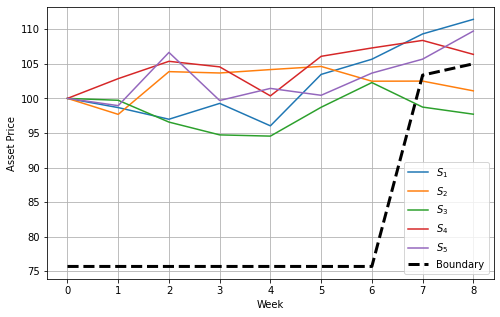

In [ ]:
#Plotting of decision boundary for American Put
#Option
time = np.arange(0,9,1)
plt.figure(figsize=(8,5))
plt.plot(time,results[212,:],label='$S_1$')
plt.plot(time,results[90,:],label='$S_2$')
plt.plot(time,results[201,:],label='$S_3$')
plt.plot(time,results[111,:],label='$S_4$')
plt.plot(time,results[89,:],label='$S_5$')
plt.plot(time,boundary,'k--',linewidth=3.0,label='Boundary')
plt.xlabel('Week')
plt.ylabel('Asset Price')
plt.legend()
plt.grid()
plt.show()
#plt.savefig('boundary.png')

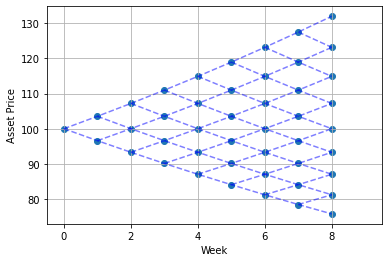

In [ ]:
#Plotting of binomial tree
#PlotBinomial(tree,dt,T,save=True)
PlotBinomial(tree,dt,T)

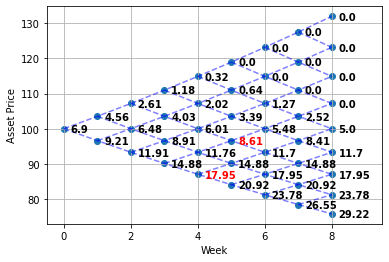

In [ ]:
#Plotting of price tree for American Put
#PlotBinomial(tree,dt,T,save=True,prices=price_tree,early=early_exercise)
PlotBinomial(tree,dt,T,prices=price_tree,early=early_exercise)

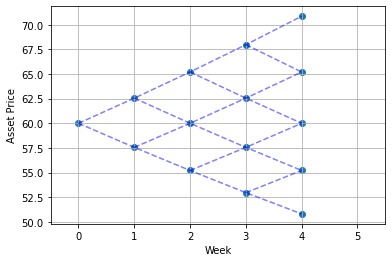

In [ ]:

#Plotting of example tree
tree_ex = BinomialLattice(60,0.05,0.3,(1/52),(4/52))
#PlotBinomial(tree_ex,dt,4/52,save=True)
PlotBinomial(tree_ex,dt,4/52)